<a href="https://colab.research.google.com/github/dborgesm/Sentiment-Analysis/blob/master/Data_preprocessing_and_Embeddings.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data preprocessing

In [0]:
%tensorflow_version 2.x
# General imports
import string
import numpy as np
import pandas as pd
import sklearn.feature_extraction as skprep
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from itertools import compress
import seaborn as sns
import random
random.seed(251082976)
%matplotlib inline

# Keras imports
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Embedding, Reshape, MaxPooling1D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten, Dense, Dropout, Lambda
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD, RMSprop, Adam
from tensorflow.keras.metrics import categorical_crossentropy, categorical_accuracy
from tensorflow.keras.layers import *
from tensorflow.keras.preprocessing import image, sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Lemmatizer libraries
import nltk
nltk.download('wordnet')
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')


TensorFlow 2.x selected.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [0]:
!gdown https://drive.google.com/uc?id=1Yh50gZOHTISHj6GPhaV1uGzZGtmPZyR6


Downloading...
From: https://drive.google.com/uc?id=1Yh50gZOHTISHj6GPhaV1uGzZGtmPZyR6
To: /content/Full_Data.csv
38.4MB [00:00, 122MB/s] 


In [0]:
# Reading the data set
data = pd.read_csv('/content/Full_Data.csv', encoding="Latin-1")

In [0]:
data.head()

In [0]:
data.shape

(204058, 3)

**The confidence parameter was going to be helpful to determine how strong is the sentiment for each case (strongly positve, neutral positive, weakly positive and so fort). I will be removing the sentences where the confidence level is less than 0 they do not capture the sentiment of the reviewers.**

**Also, there are many values where the confidence where above 1, this cases mean that the person is really confidence about the postive or negative sentiment. It was assumed that the values greater than 1 were humans errors, hence they were converted to percentage instead.**

In [0]:
def new_confidence(x):
  if x > 1: 
    return x/100
  else: 
    return x

In [0]:
data['new_confidence'] = data.apply(lambda x: new_confidence(x['confidence']), axis =1)

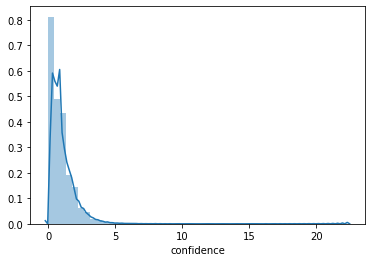

In [0]:
sns.distplot(data["confidence"])

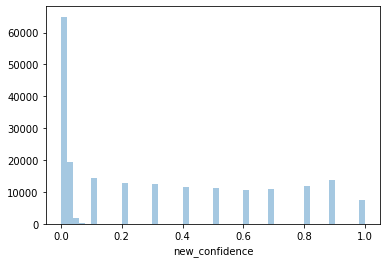

In [0]:
sns.distplot(data["new_confidence"], kde=False)

In [0]:
data = data.loc[(data.new_confidence > 0.1)]

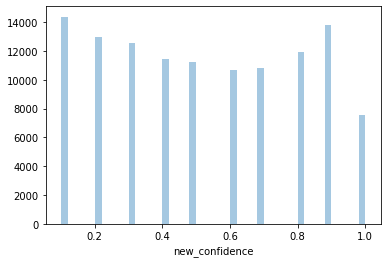

In [0]:
sns.distplot(data["new_confidence"], kde=False)

In [0]:
data.new_confidence.value_counts(bins=2)

(-0.002, 0.5]    149194
(0.5, 1.0]        54864
Name: new_confidence, dtype: int64

**The confidence parameter was going to be helpful to determine how strong is the sentiment for each case (strongly positve, neutral positive, weakly positive and so fort). However after normalization, most of the values are weakly positve (less than 0.5). Also will be removing the sentences where the confidence level is less than 0.001 they do not capture the sentiment of the reviewers.**

In [0]:
from bs4 import BeautifulSoup
import re
import itertools
#import emoji

In [0]:
data['pre_clean_len'] = [len(t) for t in data.text]
from pprint import pprint
data_dict = {
    'sentiment':{
        'type':data.sentiment.dtype,
        'description':'sentiment class - 0:negative, 1:positive'
    },
    'text':{
        'type':data.text.dtype,
        'description':'sentence text'
    },
    'pre_clean_len':{
        'type':data.pre_clean_len.dtype,
        'description':'Length of the sentence before cleaning'
    },
    'dataset_shape':data.shape
}

print(data_dict)

{'sentiment': {'type': dtype('int64'), 'description': 'sentiment class - 0:negative, 1:positive'}, 'text': {'type': dtype('O'), 'description': 'sentence text'}, 'pre_clean_len': {'type': dtype('int64'), 'description': 'Length of the sentence before cleaning'}, 'dataset_shape': (181538, 5)}


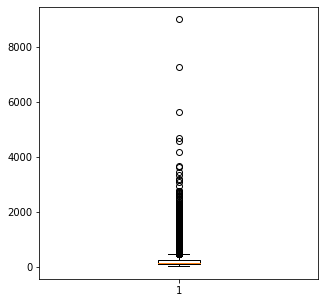

In [0]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(data.pre_clean_len)
plt.show()

In [0]:
data['pre_word_num'] = [len(t.split()) for t in data.text]

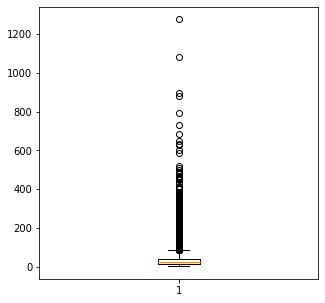

In [0]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(data.pre_word_num)
plt.show()

**There are some reviews that do not contain important information for the model (words less than 4), for example CSS, itai. Hence these records  will be removed.**

In [0]:
data = data[data.pre_clean_len > 4]
data.reset_index(inplace=True)

In [0]:
data.pre_clean_len.describe()

count    181516.000000
mean        178.797742
std         163.652889
min           5.000000
25%          74.000000
50%         134.000000
75%         233.000000
max        8999.000000
Name: pre_clean_len, dtype: float64

**Finding how many sentences have url links**



In [0]:
counter = 0
for s in data.text:
  c = re.findall(r'(\w+:\/\/\S+)',s)
  if c != []:
    counter=counter+1

In [0]:
counter

5078

**There are only 5078 sentences with urls meaning that including them in the data won't be necessary.**

Steps for data preprocessing:

- Setting all sentence to lower case
- Removing websites
- Removing of punctuation
- Labeling emojis
- Removing character removal
- Replacing contractions
-

In [0]:
def load_dict_smileys():
    
    return {
        "; )":"smiley",
        ";)":"smiley",
        ";D":"smiley",
        "; D":"smiley",
        ":-)":"smiley",
        ": )":"smiley",
        ":‑)":"smiley",
        ":-]":"smiley",
        ":-3":"smiley",
        ":->":"smiley",
        "8-)":"smiley",
        ":-}":"smiley",
        ":)":"smiley",
        ":]":"smiley",
        ":3":"smiley",
        ":>":"smiley",
        "8)":"smiley",
        ":}":"smiley",
        ":o)":"smiley",
        ":c)":"smiley",
        ":^)":"smiley",
        "=]":"smiley",
        "=)":"smiley",
        ":-))":"smiley",
        ":‑D":"smiley",
        "8‑D":"smiley",
        "x‑D":"smiley",
        "X‑D":"smiley",
        ": D":"smiley",
        ":D":"smiley",
        "8D":"smiley",
        "xD":"smiley",
        "XD":"smiley",
        ": (":"sad",
        ":,(":"sad",
        ":‑(":"sad",
        ":‑c":"sad",
        ":‑<":"sad",
        ":‑[":"sad",
        ":(":"sad",
        ":c":"sad",
        ":<":"sad",
        ":[":"sad",
        ":-||":"sad",
        ">:[":"sad",
        ":{":"sad",
        ":@":"sad",
        ">:(":"sad",
        ":'‑(":"sad",
        ":'(":"sad",
        ":‑P":"playful",
        "X‑P":"playful",
        "x‑p":"playful",
        ":‑p":"playful",
        ":‑Þ":"playful",
        ":‑þ":"playful",
        ":‑b":"playful",
        ":P":"playful",
        "XP":"playful",
        "xp":"playful",
        ":p":"playful",
        ":Þ":"playful",
        ":þ":"playful",
        ":b":"playful",
        "<3":"love",
        "< 3":"love"
        }


def load_dict_contractions():
    
    return {
        "ain't":"is not",
        "amn't":"am not",
        "aren't":"are not",
        "can't":"cannot",
        "'cause":"because",
        "couldn't":"could not",
        "couldn't've":"could not have",
        "could've":"could have",
        "daren't":"dare not",
        "daresn't":"dare not",
        "dasn't":"dare not",
        "didn't":"did not",
        "doesn't":"does not",
        "don't":"do not",
        "e'er":"ever",
        "em":"them",
        "everyone's":"everyone is",
        "finna":"fixing to",
        "gimme":"give me",
        "gonna":"going to",
        "gon't":"go not",
        "gotta":"got to",
        "hadn't":"had not",
        "hasn't":"has not",
        "haven't":"have not",
        "he'd":"he would",
        "he'll":"he will",
        "he's":"he is",
        "he've":"he have",
        "how'd":"how would",
        "how'll":"how will",
        "how're":"how are",
        "how's":"how is",
        "i'd":"i would",
        "i'll":"i will",
        "i'm":"i am",
        "i'm'a":"i am about to",
        "i'm'o":"i am going to",
        "isn't":"is not",
        "it'd":"it would",
        "it'll":"it will",
        "it's":"it is",
        "i've":"i have",
        "kinda":"kind of",
        "let's":"let us",
        "mayn't":"may not",
        "may've":"may have",
        "mightn't":"might not",
        "might've":"might have",
        "mustn't":"must not",
        "mustn't've":"must not have",
        "must've":"must have",
        "needn't":"need not",
        "ne'er":"never",
        "o'":"of",
        "o'er":"over",
        "ol'":"old",
        "oughtn't":"ought not",
        "shalln't":"shall not",
        "shan't":"shall not",
        "she'd":"she would",
        "she'll":"she will",
        "she's":"she is",
        "shouldn't":"should not",
        "shouldn't've":"should not have",
        "should've":"should have",
        "somebody's":"somebody is",
        "someone's":"someone is",
        "something's":"something is",
        "that'd":"that would",
        "that'll":"that will",
        "that're":"that are",
        "that's":"that is",
        "there'd":"there would",
        "there'll":"there will",
        "there're":"there are",
        "there's":"there is",
        "these're":"these are",
        "they'd":"they would",
        "they'll":"they will",
        "they're":"they are",
        "they've":"they have",
        "this's":"this is",
        "those're":"those are",
        "'tis":"it is",
        "'twas":"it was",
        "wanna":"want to",
        "wasn't":"was not",
        "we'd":"we would",
        "we'd've":"we would have",
        "we'll":"we will",
        "we're":"we are",
        "weren't":"were not",
        "we've":"we have",
        "what'd":"what did",
        "what'll":"what will",
        "what're":"what are",
        "what's":"what is",
        "what've":"what have",
        "when's":"when is",
        "where'd":"where did",
        "where're":"where are",
        "where's":"where is",
        "where've":"where have",
        "which's":"which is",
        "who'd":"who would",
        "who'd've":"who would have",
        "who'll":"who will",
        "who're":"who are",
        "who's":"who is",
        "who've":"who have",
        "why'd":"why did",
        "why're":"why are",
        "why's":"why is",
        "won't":"will not",
        "wouldn't":"would not",
        "would've":"would have",
        "y'all":"you all",
        "you'd":"you would",
        "you'll":"you will",
        "you're":"you are",
        "you've":"you have",
        "whatcha":"what are you",
        "luv":"love",
        "sux":"sucks",
        "nd":"and"
        }

def data_cleaning(sentence):    
    
    #Escaping HTML characters
    sentence = BeautifulSoup(sentence).get_text()
    #Special case not handled previously.
    sentence = sentence.replace('\x92',"'")
    #Removing url
    sentence = re.sub('https?://[A-Za-z0-9./]+','',sentence)
    #Removal of hastags/account
    SMILEY = load_dict_smileys()  
    words = sentence.split()
    reformed = [SMILEY[word] if word in SMILEY.keys() else word for word in words]
    sentence = " ".join(reformed)
    #Removal of hastags/account
    sentence = ' '.join(re.sub("(@[A-Za-z0-9]+)|(#[A-Za-z0-9]+)", " ", sentence).split())
    #Removal of address
    sentence = ' '.join(re.sub("(\w+:\/\/\S+)", " ", sentence).split())
    #Removal of Punctuation
    sentence = ' '.join(re.sub("[\.\,\!\?\:\;\-\=\@]", " ", sentence).split())
    #Lower case
    sentence = sentence.lower()

    #CONTRACTIONS source: https://en.wikipedia.org/wiki/Contraction_%28grammar%29
    CONTRACTIONS = load_dict_contractions()
    sentence = sentence.replace("’","'")
    words = sentence.split()
    reformed = [CONTRACTIONS[word] if word in CONTRACTIONS else word for word in words]
    sentence = " ".join(reformed)
    # Standardizing words
    sentence = ''.join(''.join(s)[:2] for _, s in itertools.groupby(sentence))

    sentence = re.sub('[^a-zA-Z]', ' ', sentence)

    # Removing numbers
    sentence = re.sub(r'\d+','',sentence)
    # Single character removal
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)

    # Removing multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)

    sentence = sentence.strip()
    # DO NOT REMOVE STOP WORDS FOR SENTIMENT ANALYSIS - OR AT LEAST NOT NEGATIVE ONES

    return sentence

In [0]:
# Cleaning the data
data.text = data.apply(lambda x: data_cleaning(x['text']), axis=1 )

/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "http://s205.photobucket.com/user/RByers91/media/EDC%20Related/fbb9a67d-b062-48d8-aa63-4200fdef267f.jpg.htmlâ¦" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "https://forum.pjrc.com/threads/38029-Who-has-already-got-his-her-kickstarter-teensies-(international-shipping)" looks like a URL. Beautiful Soup is not an HTTP client. You should probably use an HTTP client like requests to get the document behind the URL, and feed that document to Beautiful Soup.
  ' that document to Beautiful Soup.' % decoded_markup
/usr/local/lib/python3.6/dist-packages/bs4/__init__.py:336: UserWarning: "https://twitter.com/holi_officialâ¦
https://www.vocall.ai/
https://me

**Removing conjuctions and other words that do not add significant meaning**

In [0]:
stop_words_conj = {'for',
              'and',
              'nor',
              'but',
              'or',
              'yet',
              'so',
              'after',
              'although',
              'as',
              'as if',
              'as long as',
              'as much as',
              'as soon as',
              'as though',
              'because', 
              'before', 
              'by the time', 
              'even if',
              'even though',
              'if', 
              'in order that',
              'in case',
              'lest',
              'once',
              'only if',
              'since',
              'so that',
              'than',
              'that',
              'though',
              'till',
              'unless',
              'until',
              'what',
              'when',
              'whenever',
              'where',
              'wherever',
              'while',
              'both',
              'either',
              'neither',
              'not only',
              'but also',
              'whether',
              'in',
              'on',
              'from',
              'who',
              'which',
              'whom',
              'so',
              'by',
              'between',
              'whom',
              'this',
              'these',
              'those',
              'up',
              'too',
              'to',
              'once',
              'only',
              'such',
              'into',
              'most',
              'more',
              'of',
              'a',
              'an',
              'the',
              'then',
              'there',
              'with',
              'up',
              'how',
              'few',
              'below',
              'down',
              'it',
              'wa'}

In [0]:
# Removing stop words and lemmatizing 
stop_words = set(stopwords.words('english'))
# We will not eliminate not from the data because we already have done haven't to have not, being not a negative 
st_words = []
for w in stop_words:
  if (w != "not") & (w != "no"):
    st_words.append(w)


## Removing Stop Words and using Lemmatization

**Only not negative stop words will be removed, because if we have this phrase "I am not happy" and not is remove the final phrase that the model will analize after cleaning is "happy" which will be incorrect because the sentiment in this phrase is negative.**

**Also, lemmatization will be used, which "reduces the inflected words properly ensuring that the root word belongs to the language". (DataCamp)**


In [0]:
# Removing stop words and lemmatizing. 

def st_lem(sentence,sentiment):
  sentence = sentence.split()
  filtered_sentence = [w for w in sentence if not w in stop_words_conj]
  new_sen = []
  sentiment = 0
  if sentiment == 1:
    m = "v"
  else:
    m = "n"
  
  for s in filtered_sentence:
    k = wordnet_lemmatizer.lemmatize(s, pos=m)
    new_sen.append(k)

  sentence = " ".join(new_sen)
  # Single character removal
  sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
  
  return sentence  

In [0]:
data.text = data.apply(lambda x: st_lem(x['text'],x['sentiment']), axis=1 )

/usr/local/lib/python3.6/dist-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


In [0]:
#Counting the lenght of the sentences after cleaning
data['pos_clean_len'] = [len(t) for t in data.text]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
data['pos_word_number'] = [len(t.split()) for t in data.text]

In [0]:
data.drop(['index'], inplace=True, axis=1)

In [0]:
data.head()

,text,sentiment,confidence,confidence_norm,pre_clean_len,pre_word_num,pos_clean_len,pos_word_number
0,trying wait patient can lol,1,0.3,0.013453,37,9,27,5
1,good morning fotopro team noticed some comment...,1,0.6,0.026906,182,34,131,23
2,still track ahead behind,1,0.2,0.008969,36,6,24,4
3,product nice had get twice,1,0.5,0.022422,35,8,26,5
4,just curious will you have any extension goal ...,1,0.4,0.017937,106,21,71,14


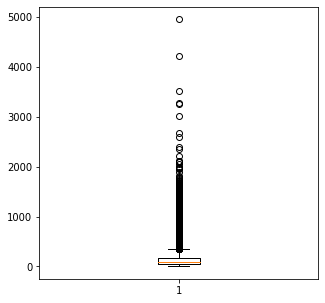

In [0]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(data.pos_clean_len)
plt.show()


In [0]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(data.word_number)
plt.show()


In [0]:
data.pos_word_number.describe()

count    181516.000000
mean         22.367598
std          19.563486
min           0.000000
25%          10.000000
50%          17.000000
75%          29.000000
max         807.000000
Name: pos_word_number, dtype: float64

In [0]:
data.word_number.describe()

**After cleaning the reviews less than 4 letters will be removed, again they are just saying random names or are blank spaces.**

In [0]:
data = data[data.pos_clean_len >= 4]
data.reset_index(inplace=True, drop=True)

In [0]:
data.pos_clean_len.describe()

count    181388.000000
mean        131.272240
std         118.326063
min           4.000000
25%          55.000000
50%          99.000000
75%         171.000000
max        4954.000000
Name: pos_clean_len, dtype: float64

In [0]:
data[data.pos_word_number == 42 ].text

8         hi looking forward getting product size tablet...
72        duty pay local value added tax may change depe...
96        got bag month ago first day using button insid...
663       yay rt arrived today playing first impression ...
880       please respond email people chose refund optio...
                                ...                        
203179    backer think time start considering legal opti...
203204    message backer ignored sectorqube time time pl...
203207    creator perfectly fine delay crowdfunded proje...
203433    got mine christmas finally gotten chance play ...
203540    provide better instruction later add pin jst c...
Name: text, Length: 932, dtype: object

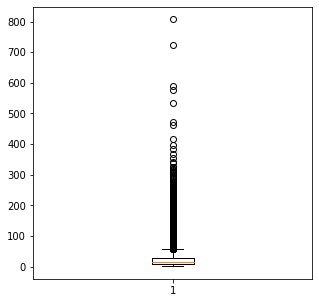

In [0]:
fig, ax = plt.subplots(figsize=(5, 5))
plt.boxplot(data.pos_word_number)
plt.show()

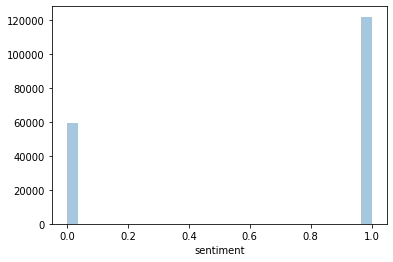

In [0]:
sns.distplot(data.sentiment, kde=False)

In [0]:
data.sentiment.value_counts()

1    122021
0     59367
Name: sentiment, dtype: int64

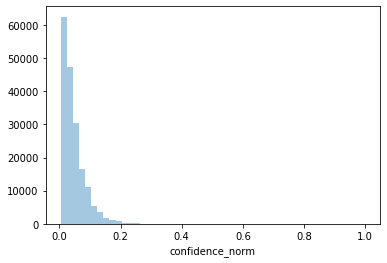

In [0]:
sns.distplot(data.confidence_norm,kde=False)

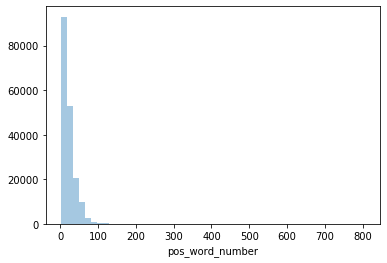

In [0]:
sns.distplot(data.pos_word_number,kde=False)

In [0]:
data.clean_word_count.value_counts()

In [0]:
from io import StringIO
import csv

In [0]:
data

,text,sentiment,confidence,confidence_norm,pre_clean_len,pre_word_num,pos_clean_len,pos_word_number
0,trying wait patient can lol,1,0.3,0.013453,37,9,27,5
1,good morning fotopro team noticed some comment...,1,0.6,0.026906,182,34,131,23
2,still track ahead behind,1,0.2,0.008969,36,6,24,4
3,product nice had get twice,1,0.5,0.022422,35,8,26,5
4,just curious will you have any extension goal ...,1,0.4,0.017937,106,21,71,14
...,...,...,...,...,...,...,...,...
181383,i am curious you have looked at working partic...,1,0.7,0.031390,239,39,200,34
181384,looking forward another awesome campaign kevin...,1,1.7,0.076233,86,15,70,11
181385,nice thanks all answer cheer,1,1.4,0.062780,37,6,28,5
181386,wink wa still amazing wa le enthusiast about p...,1,1.7,0.076233,226,42,172,30


In [0]:
data['label'] = data['sentiment']

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
# selection the columns that will be useful
col = ["label","text"]
clean_data = data[col]

In [0]:
clean_data

,label,text
0,1,trying wait patient can lol
1,1,good morning fotopro team noticed some comment...
2,1,still track ahead behind
3,1,product nice had get twice
4,1,just curious will you have any extension goal ...
...,...,...
181383,1,i am curious you have looked at working partic...
181384,1,looking forward another awesome campaign kevin...
181385,1,nice thanks all answer cheer
181386,1,wink wa still amazing wa le enthusiast about p...


In [0]:
len(clean_data.text)*.70

126971.59999999999

In [0]:
len(clean_data.text)*.30

54416.4

In [0]:
clean_data.shape

(181388, 2)

# Training embeddings
## fasttext

The last version of fasttext will be used [fasttext embeddings](https://github.com/facebookresearch/fastText)



In [0]:
!wget https://github.com/facebookresearch/fastText/archive/v0.9.1.zip
  
!unzip v0.9.1.zip

**Compiling the library using the command make**



In [0]:
%cd fastText-0.9.1
!make

In [0]:
!wget https://dl.fbaipublicfiles.com/fasttext/vectors-crawl/cc.en.300.bin.gz # WIkipeduo with subword information for the course work embedding

!gunzip -v -f cc.en.300.bin.gz
#!wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M-subword.bin.zip
#!gunzip -v -f wiki-news-300d-1M-subword.bin.zip

#! wget https://dl.fbaipublicfiles.com/fasttext/vectors-english/wiki-news-300d-1M-subword.vec.zip

In [0]:
# Come back to the original work folder
%cd /content

In [0]:
tokenizer = Tokenizer() # Creates tokenizer model.
tokenizer.fit_on_texts(clean_data.text) # Trains it over the tokens that we have.

# Get words
Vals = list(tokenizer.word_index.keys())

In [0]:
import codecs
# Write CSV with the output.
file = codecs.open('cw3Words.csv', "w", "utf-8") #Save the words in here

for item in Vals:
    file.write("%s\r\n" % item)
    
file.close()

In [0]:
!head cw3Words.csv

In [0]:
!ls

cw3Words.csv  fastText-0.9.1  Full_Data.csv  sample_data  v0.9.1.zip


In [0]:
# Getting the embeddings
!./fastText-0.9.1/fasttext print-sentence-vectors fastText-0.9.1/cc.en.300.bin < cw3Words.csv > Embeddingcw3.tsv

tcmalloc: large alloc 4800004096 bytes == 0x55eac67de000 @  0x7f81b110c887 0x55eab381085f 0x55eab381bae4 0x55eab381c5d1 0x55eab3828113 0x55eab37f1ef8 0x7f81b01a9b97 0x55eab37f1f8a
tcmalloc: large alloc 2400002048 bytes == 0x55ebe4982000 @  0x7f81b110c887 0x55eab381085f 0x55eab381bb28 0x55eab381c5d1 0x55eab3828113 0x55eab37f1ef8 0x7f81b01a9b97 0x55eab37f1f8a


In [0]:
!head Embeddingcw3.tsv

-0.043788 0.010765 -0.0093959 0.17058 -0.063025 -0.041678 -0.037263 -0.044098 0.01462 -0.028619 -0.0059088 0.029382 0.0048629 -0.0089858 0.0034845 0.069706 0.012286 -0.015933 -0.021485 0.13178 -0.002054 0.0032793 0.028974 0.0048759 0.047416 -0.039125 -0.022167 0.0041181 0.013321 0.014957 -0.067949 0.0088651 0.012891 0.032443 -0.017372 -0.012832 -0.021684 0.0031289 0.060738 -0.030396 -0.0049018 -0.0036517 0.024868 0.046457 -0.010245 -0.015817 -0.0093585 -0.035147 -0.0051291 -0.018584 -0.05635 -0.0092457 0.016998 -0.011408 -0.0077003 0.019772 -0.019994 -0.11217 -0.111 -0.00021544 -0.041821 -0.0025578 -0.026482 -0.086762 -0.025815 -0.021474 -0.018721 -0.0099812 -0.0052388 -0.017952 -0.071238 -0.0074522 0.057443 -0.02947 0.0068156 0.011459 0.055759 0.058265 -0.11308 -0.13251 -0.033243 0.021942 -0.030434 0.083691 -0.02453 -0.025112 0.095722 -0.075692 0.017203 0.10259 -0.026604 -0.038565 0.072339 -0.016736 0.027283 -0.033852 -0.13892 0.026435 -0.042506 -0.035658 0.0031628 0.012742 -0.01137 -

In [0]:
from keras.preprocessing.text import text_to_word_sequence
total_tokens =[]
for i in range(len(clean_data.text)):
    total_tokens.append(text_to_word_sequence(clean_data.text[i]))
t = np.array(total_tokens)

Using TensorFlow backend.


In [0]:
c =[]
for w in range(len(data.text)):
    for k in t[w]:
            c.append(k)

In [0]:
# Most use words
v = pd.DataFrame(c)
v[0].value_counts().head(50)

you         107545
is           95373
have         71027
not          64200
my           59495
we           57296
will         46106
be           44238
are          44165
your         41763
can          30841
i            28415
am           26773
do           25513
would        24391
just         24269
thanks       23856
get          23742
wa           23676
all          23108
update       22841
they         20080
at           19900
me           19844
out          19403
received     19376
one          19230
please       18611
any          18516
no           17529
like         17376
our          16655
about        16426
hi           16210
still        15659
been         14771
product      14475
thank        14410
now          14335
time         14319
ha           13795
project      13096
backer       12993
great        12733
some         12646
very         12631
know         12601
got          12543
order        12413
shipping     12355
Name: 0, dtype: int64

In [0]:
import fileinput
#Replace all spaces by commas and create a csv
with fileinput.FileInput('Embeddingcw3.tsv', inplace=True, backup='.bak') as file:
    for line in file:
        print(line.replace(' ', ','), end='')

In [0]:
import numpy as np
import os

# Create the first line
firstLine = ','.join(['D'+str(i) for i in np.arange(1, 301)]) + '\n'

# Open as read only. Read the file
with open('Embeddingcw3.tsv', 'r') as original: 
  data = original.read()

# Open to write and write the first line and the rest
with open('Embeddingcw3.csv', 'w') as modified: 
  modified.write(firstLine + data)

In [0]:
!head Embeddingcw3.csv

D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,D16,D17,D18,D19,D20,D21,D22,D23,D24,D25,D26,D27,D28,D29,D30,D31,D32,D33,D34,D35,D36,D37,D38,D39,D40,D41,D42,D43,D44,D45,D46,D47,D48,D49,D50,D51,D52,D53,D54,D55,D56,D57,D58,D59,D60,D61,D62,D63,D64,D65,D66,D67,D68,D69,D70,D71,D72,D73,D74,D75,D76,D77,D78,D79,D80,D81,D82,D83,D84,D85,D86,D87,D88,D89,D90,D91,D92,D93,D94,D95,D96,D97,D98,D99,D100,D101,D102,D103,D104,D105,D106,D107,D108,D109,D110,D111,D112,D113,D114,D115,D116,D117,D118,D119,D120,D121,D122,D123,D124,D125,D126,D127,D128,D129,D130,D131,D132,D133,D134,D135,D136,D137,D138,D139,D140,D141,D142,D143,D144,D145,D146,D147,D148,D149,D150,D151,D152,D153,D154,D155,D156,D157,D158,D159,D160,D161,D162,D163,D164,D165,D166,D167,D168,D169,D170,D171,D172,D173,D174,D175,D176,D177,D178,D179,D180,D181,D182,D183,D184,D185,D186,D187,D188,D189,D190,D191,D192,D193,D194,D195,D196,D197,D198,D199,D200,D201,D202,D203,D204,D205,D206,D207,D208,D209,D210,D211,D212,D213,D214,D215,D216,D217,D218,D219,D220,D221,D22

## Using the Embedding Layer

1. Read the embeddings.
2. Calculate the One-Hot inputs (by using an "index") which will index which words are in which text.
3. Train the model.

In [0]:
# Read word embeddings
Embeddings = pd.read_csv('Embeddingcw3.csv', sep=',', decimal = '.', 
                         low_memory = True, index_col = False)
Embeddings.describe()

,D1,D2,D3,D4,D5,D6,D7,D8,D9,D10,D11,D12,D13,D14,D15,D16,D17,D18,D19,D20,D21,D22,D23,D24,D25,D26,D27,D28,D29,D30,D31,D32,D33,D34,D35,D36,D37,D38,D39,D40,...,D261,D262,D263,D264,D265,D266,D267,D268,D269,D270,D271,D272,D273,D274,D275,D276,D277,D278,D279,D280,D281,D282,D283,D284,D285,D286,D287,D288,D289,D290,D291,D292,D293,D294,D295,D296,D297,D298,D299,D300
count,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,...,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000,60880.000000
mean,-0.006304,-0.005513,-0.009287,0.058734,-0.009031,-0.011967,0.003203,0.002184,-0.002204,-0.000249,-0.008160,-0.001446,0.009244,-0.009041,-0.004431,-0.017038,0.009803,0.002753,-0.001231,0.013833,-0.009577,-0.001007,0.009050,0.001477,0.022589,-0.003618,-0.007055,0.007901,-0.003643,0.086296,-0.004810,-0.004866,-0.001911,0.011335,0.012324,-0.001048,0.009728,0.029601,-0.005392,0.009393,...,0.000660,-0.013176,-0.020835,-0.000793,-0.019864,-0.010403,-0.000987,-0.005383,-0.001321,0.025343,-0.010593,0.004603,-0.035150,-0.015149,0.004780,0.004764,-0.014996,0.012079,-0.022158,-0.004456,0.003952,-0.008503,-0.049442,0.004655,-0.003926,0.002903,-0.002118,-0.029322,0.007562,-0.018074,0.023308,-0.003891,-0.065893,0.018224,0.007297,-0.000454,0.003210,0.055287,-0.001318,-0.007853
std,0.052772,0.051021,0.053456,0.056589,0.060404,0.061678,0.052560,0.056877,0.051247,0.054131,0.057032,0.052874,0.053319,0.053675,0.054180,0.063163,0.061301,0.053030,0.055912,0.055086,0.052744,0.056193,0.053934,0.051149,0.056844,0.055162,0.051233,0.055871,0.051472,0.099625,0.052627,0.052151,0.052214,0.059912,0.054636,0.050689,0.057876,0.061682,0.049578,0.055556,...,0.052410,0.060662,0.093696,0.055155,0.053585,0.052793,0.056580,0.049157,0.055305,0.064892,0.056232,0.059699,0.055949,0.050407,0.052231,0.050916,0.054592,0.050981,0.054407,0.054163,0.052352,0.051771,0.047948,0.055746,0.051561,0.058395,0.053545,0.077654,0.061207,0.055987,0.059829,0.052118,0.065352,0.055033,0.050828,0.053617,0.053319,0.046279,0.056756,0.054957
min,-0.228820,-0.266600,-0.264120,-0.220330,-0.318070,-0.313930,-0.303280,-0.277600,-0.253600,-0.247880,-0.248430,-0.259920,-0.226370,-0.259790,-0.246870,-0.401370,-0.223950,-0.253360,-0.256640,-0.275970,-0.210840,-0.239250,-0.227680,-0.206130,-0.244240,-0.231870,-0.225980,-0.234880,-0.238730,-0.441230,-0.231150,-0.243860,-0.219110,-0.346300,-0.223820,-0.257210,-0.288180,-0.286950,-0.218390,-0.238480,...,-0.232400,-0.346610,-0.400470,-0.244580,-0.353160,-0.249380,-0.242550,-0.194530,-0.278300,-0.312930,-0.263800,-0.231340,-0.354660,-0.291520,-0.224110,-0.255290,-0.350560,-0.252830,-0.291900,-0.356230,-0.244270,-0.235390,-0.385320,-0.244720,-0.273080,-0.307930,-0.230690,-0.323840,-0.286750,-0.246730,-0.284450,-0.236450,-0.378400,-0.217080,-0.217590,-0.245700,-0.245840,-0.194460,-0.266290,-0.250450
25%,-0.041519,-0.037198,-0.044135,0.023148,-0.046824,-0.053682,-0.031209,-0.035646,-0.036070,-0.036126,-0.045951,-0.034699,-0.025268,-0.043744,-0.040790,-0.048655,-0.031538,-0.031834,-0.037628,-0.021340,-0.044593,-0.037615,-0.026925,-0.032793,-0.013451,-0.041364,-0.041349,-0.02881

**Creating a dictionary for the embeddings. The zip function allows to create the (key, element) structure that we need.**

In [0]:
# Create embedding dictionary
EmbeddingsDict = dict(zip(Vals, Embeddings.values))

Avg. no of words: 22.38
Std. deviation: 19.56
Max words: 807


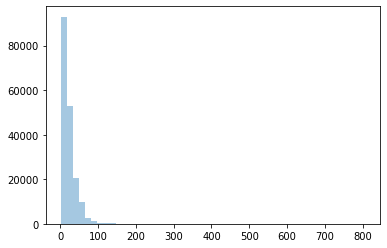

In [0]:
import seaborn as sns
import numpy as np
%matplotlib inline

# Count maximum number of words per file.
word_dist = [len(w.split()) for w in clean_data.iloc[:,1]]
print('Avg. no of words: ' + str(np.round(np.mean(word_dist), 2)))
print('Std. deviation: ' + str(np.round(np.std(word_dist), 2)))
print('Max words: ' + str(np.max(word_dist)))

# Generate the plot
dist = sns.distplot(word_dist,kde=False)

# I'm saving the image to a PDF, as it makes it easier later to download.
dist.figure.savefig("word_dist.pdf", format = "pdf")

#no of per piece of text, decide how big is going to big in the e,bedding 
# select 600 or 800 where we trim one percent

In [0]:
word_array = np.array(word_dist)

In [0]:
len(word_array)

181388

In [0]:
sum(word_array>88)

1878

**I will use 88 words maximum, because this will only remove 1% of the data.**

**Now to create the embedding layer pre padding that will add 0´s at the beggining of the sentence.**


In [0]:
clean_data.iloc[12:30,:]

,label,text
12,0,previous update you mentioned delivery startin...
13,1,good morning ha been any news
14,0,have survey been sent out
15,1,been quiet some time is project going any new ...
16,1,imran thank you much we are all excited
17,1,congratulation
18,1,nasra hey we have sent you email thanks
19,1,hi haven received mine any update plz thanks
20,1,lvarez hey we have sent you email thanks
21,0,hi did not receive is you did not deliver


In [0]:
# Create word index from input
sequences = tokenizer.texts_to_sequences(clean_data.iloc[:,1]) # Create the sequences.

# Creates the indexes. Word index is a dictionary with words in it.
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# Creates the training dataset, adding padding when necessary.
data = pad_sequences(sequences, maxlen=88, 
                     padding = 'pre') # add padding at the end. No difference in practice.

# Creates the objective function
labels = clean_data.iloc[:,0]
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 60880 unique tokens.
Shape of data tensor: (181388, 88)
Shape of label tensor: (181388,)


In [0]:
# Let's save the outputs, so we don't run all of the above 20 times.
# Be efficient! Save always save intermediate outputs

# Create saving directory
!mkdir cw3_preprocessed

# Save outputs
np.savetxt("cw3_preprocessed/cw3_padded.txt", data)
np.savetxt("cw3_preprocessed/cw3_labels.txt", labels)

In [0]:
data[0]

array([  0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0, 295,  94, 863,  11, 835], dtype=int32)

In [0]:
# Create first matrix full with 0's
embedding_matrix = np.zeros((len(word_index) + 1, 300))

# Generate embeddings matrix
for word, i in word_index.items():
    embedding_vector = EmbeddingsDict.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

# Print what came out
embedding_matrix

array([[ 0.       ,  0.       ,  0.       , ...,  0.       ,  0.       ,
         0.       ],
       [ 0.067962 , -0.027794 ,  0.084447 , ...,  0.22954  , -0.040042 ,
        -0.10308  ],
       [-0.031645 , -0.067418 , -0.033575 , ..., -0.073858 , -0.072651 ,
         0.028801 ],
       ...,
       [ 0.025399 , -0.0035609, -0.0026594, ...,  0.062831 , -0.059811 ,
        -0.051558 ],
       [-0.05492  ,  0.038278 , -0.014138 , ...,  0.031413 , -0.0369   ,
        -0.042412 ],
       [ 0.05704  ,  0.011737 , -0.057967 , ...,  0.038313 , -0.035208 ,
        -0.004399 ]])

In [0]:
# Saving the results
np.savetxt("cw3_preprocessed/cw3_embeddingmatrix.txt", embedding_matrix)

In [0]:
# We will also save the word dictionary
import pickle
f = open("WordDictionary.pkl","wb")
pickle.dump(word_index, f)
f.close()

In [0]:
# Zip all files for download.
!zip -r cw3_preprocessed.zip cw3_preprocessed 

  adding: cw3_preprocessed/ (stored 0%)
  adding: cw3_preprocessed/cw3_embeddingmatrix.txt (deflated 75%)
  adding: cw3_preprocessed/cw3_padded.txt (deflated 97%)
  adding: cw3_preprocessed/cw3_labels.txt (deflated 99%)


In [0]:
# Download files
from google.colab import files
files.download("cw3_preprocessed.zip")

In [0]:
clean_data.to_csv("data.csv", index = False)

In [0]:
files.download("data.csv")

## Glove

In [0]:
# download pretrained GloVe embeddings
!wget http://nlp.stanford.edu/data/glove.42B.300d.zip
#!wget http://nlp.stanford.edu/data/glove.6B.zip

--2019-12-10 04:54:34--  http://nlp.stanford.edu/data/glove.42B.300d.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://nlp.stanford.edu/data/glove.42B.300d.zip [following]
--2019-12-10 04:54:35--  https://nlp.stanford.edu/data/glove.42B.300d.zip
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: http://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip [following]
--2019-12-10 04:54:35--  http://downloads.cs.stanford.edu/nlp/data/glove.42B.300d.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1877800501 (1.7G) [application/zip]
Sav

In [0]:
!unzip glove.42B.300d.zip

In [0]:
glove_dir = './'

embeddings_index = {} #initialize dictionary
f = open(os.path.join(glove_dir, 'glove.42B.300d.txt'))
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


### Importing the preprocessed data

In [0]:
!gdown https://drive.google.com/uc?id=1Wif2pMZ9999uXccEVKM0L0ZJB6mBh7c5


Downloading...
From: https://drive.google.com/uc?id=1Wif2pMZ9999uXccEVKM0L0ZJB6mBh7c5
To: /content/data.csv
24.4MB [00:00, 66.8MB/s]


In [0]:
clean_data = pd.read_csv('/content/data.csv')

In [0]:
clean_data.iloc[:,1]

In [0]:
tokenizer = Tokenizer() # Creates tokenizer model.embedding_matrix
tokenizer.fit_on_texts(clean_data.text)

In [0]:
# Create word index from input
sequences = tokenizer.texts_to_sequences(clean_data.iloc[:,1]) # Create the sequences.

# Creates the indexes. Word index is a dictionary with words in it.
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

# Creates the training dataset, adding padding when necessary.
data = pad_sequences(sequences, maxlen=88, 
                     padding = 'pre') # add padding at the end. No difference in practice.

# Creates the objective function
labels = clean_data.iloc[:,0]
print('Shape of data tensor:', data.shape)
print('Shape of label tensor:', labels.shape)

Found 60880 unique tokens.
Shape of data tensor: (181388, 88)
Shape of label tensor: (181388,)


In [0]:
data

array([[   0,    0,    0, ...,  863,   11,  835],
       [   0,    0,    0, ...,   11,  260,   49],
       [   0,    0,    0, ...,  467, 1167,  767],
       ...,
       [   0,    0,    0, ...,   20,  214,  464],
       [   0,    0,    0, ...,    1,   60,  101],
       [   0,    0,    0, ...,  734,   42,   58]], dtype=int32)

In [0]:
embedding_dim = 300
num_words = len(word_index) + 1
embedding_matrix = np.zeros((num_words, 300)) #create an array of zeros with word_num rows and embedding_dim columns
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if i < num_words:
        if embedding_vector is not None:
            # Words not found in embedding index will be all-zeros.
            embedding_matrix[i] = embedding_vector

In [0]:
embedding_matrix[:6]

array([[ 0.        ,  0.        ,  0.        , ...,  0.        ,
         0.        ,  0.        ],
       [-0.045315  , -0.010389  , -0.19798   , ..., -0.41484001,
         0.11124   , -0.12042   ],
       [ 0.11396   ,  0.34503001, -0.055064  , ..., -0.37246999,
         0.2879    , -0.18029   ],
       [-0.17050999,  0.08594   , -0.0077239 , ..., -0.23204   ,
         0.17605001,  0.21544001],
       [-0.022975  ,  0.087888  , -0.24247999, ..., -0.32277   ,
         0.023121  , -0.047671  ],
       [ 0.29644999, -0.38093001, -0.36526999, ..., -0.33445999,
        -0.30215001,  0.33631   ]])

In [0]:
!mkdir glove_data

In [0]:
np.savetxt("glove_data/glove_embeddingmatrix.txt", embedding_matrix)

In [0]:
np.savetxt("glove_data/glove_padded.txt", data)
np.savetxt("glove_data/glove_labels.txt", labels)

In [0]:
# Zip all files for download.
!zip -r glove_data.zip glove_data 